In [1]:
%load_ext autoreload
%autoreload 2

# Introduction 

This is the baseline model run on train and validation to give a baseline value to compare against

# Imports 

In [2]:
import pandas as pd
import numpy as np
import torch

from utils.setup_nodes import create_edge_lists
from utils.graph_helpers import train_model, plot_train_val_loss, final_evaluation
from utils.graph_model import Base_GNN_Model
from utils.general import seed_everything
from utils.predictions import recommend_products, pretty_print_recomendations, get_top_k_preds

# Set seed

In [3]:
seed_everything()

# Set variables 

In [4]:
user_split = "train_test_valid"
prod_embed_name = "meta_features_512"
user_embed_name = "user_reviews_features_512"

data_dir = "data"
product_dir = "full_data"
embedding_dir = "embedding"

device = "cuda"

product_cols = ["parent_asin", "average_rating", "rating_number"]
user_cols = ["user_id", "rating_mean", "rating_count", "helpful_vote_mean", "helpful_vote_gte_1", "verified_purchase_mean", "last_active_in_days_min",
            "last_active_in_days_max", "word_count_mean"]
edge_cols = ["user_id", "parent_asin", "rating"]

fill_users = "zero"

# Load data

Take special attention to what is being loaded as a the test set.  
Remember if you want test data, set the value of `user_split` to `train_test` in the previous cell

Also, I am limiting the number of columns being read in. So edit accordingly to what colum values are needed for the current set up 

If there is more than 1 tensor for the embedding, sugesstion is to do a torch.cat into a single longer tensor first and then carry it on to the next step. So load under different name then join it back to as product_emebdding, train_user_embedding and test_user_embedding

In [5]:
product_df = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = product_cols)
train_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/train_agg.parquet", columns = user_cols)
train_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/train.parquet", columns = edge_cols)

if user_split == "train_test_valid":
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/valid_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/valid.parquet", columns = edge_cols)
else:
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/test_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/test.parquet", columns = edge_cols)


In [6]:
product_embedding = torch.load(f"{data_dir}/{embedding_dir}/product/{prod_embed_name}.pt")
train_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/train_{user_embed_name}.pt")
if user_split == "train_test_valid":
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/valid_{user_embed_name}.pt")
else:
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/test_{user_embed_name}.pt")

# Make nodes

We need to do a few things
1. Make a super user df - so that all the nodes are inside the graph and the idx would be correct later
2. Set up an index mapping from ids to idx (note that the product index need to be offeset)
3. Concat information to form the product nodes
4. Concat information to form the user nodes - only for the train users, test users need to init as something if they dont exist in train (maybe zero or mean)
5. Create edge list for train and test (using the idx) 

For product nodes, we assume the df has information, less the ids. If there is no information, then change the creation accordingly  

For the user nodes, for users in test but not in train, the current method is to user zero.  
There is also a flag to fill with mean instead 

In [7]:
# Add the embedding 
train_user_df["embedding"] = list(train_user_embedding.numpy())
test_user_df["embedding"] = list(test_user_embedding.numpy())

# Concat user nodes 
additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()

## these are users that need to be zero-ed out 
additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()
additional_test_users["embedding"] = list(torch.zeros((len(additional_test_users), test_user_embedding.shape[1])).numpy())
if fill_users == "zero":
    additional_test_users.iloc[:, 1:-1] = 0
elif fill_users == "mean":
    additional_test_users.iloc[:, 1:-1] = train_user_df.iloc[:, 1:].mean()

# Make super user df
user_df = pd.concat([train_user_df, additional_test_users])

In [8]:
# Set up id mapping
offset = user_df.user_id.nunique()
user_id_to_idx = {unique_id : idx for idx, unique_id in enumerate(user_df.user_id.unique())}
prod_id_to_idx = {unique_id : offset + idx for idx, unique_id in enumerate(product_df.parent_asin.unique())}

# Add to df
product_df["prod_idx"] = product_df.parent_asin.apply(lambda x: prod_id_to_idx[x])
train_user_edges["user_idx"] = train_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
test_user_edges["user_idx"] = test_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
train_user_edges["prod_idx"] = train_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])
test_user_edges["prod_idx"] = test_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])

In [9]:
# Concat product nodes 
product_nodes = torch.cat([torch.tensor(product_df.drop(["parent_asin", "prod_idx"], axis = 1).to_numpy()), product_embedding], dim = 1)

In [10]:
# concat user nodes 
user_embed = torch.tensor(np.vstack(user_df["embedding"].values))
user_info = torch.tensor(user_df.drop(["user_id", "embedding"], axis = 1).to_numpy())
user_nodes = torch.cat([user_info, user_embed], dim = 1)

In [11]:
# Create edge list
train_edge_index, train_edge_weights = create_edge_lists(train_user_edges)
test_edge_index, test_edge_weights = create_edge_lists(train_user_edges)

# Move to GPU 

This is placed here for clarity 

In [12]:
product_nodes = product_nodes.type(torch.float).to(device)
user_nodes = user_nodes.type(torch.float).to(device)
train_edge_index = train_edge_index.to(device)
train_edge_weights = train_edge_weights.to(device)
test_edge_index = test_edge_index.to(device)
test_edge_weights = test_edge_weights.to(device)

# Instantiate the model

Whatever the model is decided, create it here  
ideally assign it to model so easier for the overall run  

The model when instantiating will take in the following variables (based on the default architecture that we are doing)
1. number of users - create extra embeddings for each user
2. number of products - create extra embedding for each product
3. user feature dimensions - size of self created information for users
4. product feature dimensions - size of self created information for products
5. embedding dim - what size the features reduce to (for default base model, this was the same for every place)

If you make any changes, feel free to edit accordingly

Finally don't forget to move the model to gpu 

In [13]:
# Set up model features
num_users = len(user_df)
num_products = len(product_df)
user_feature_dim = user_nodes.shape[1]
product_feature_dim = product_nodes.shape[1]
embedding_dim = 64

In [14]:
# Instantiate the model
model = Base_GNN_Model(num_users, num_products, user_feature_dim, product_feature_dim, embedding_dim)

In [15]:
# move the model 
model.to(device)

Base_GNN_Model(
  (user_embedding): Embedding(383703, 64)
  (product_embedding): Embedding(89060, 64)
  (user_feature_transform): Linear(in_features=776, out_features=64, bias=True)
  (product_feature_transform): Linear(in_features=770, out_features=64, bias=True)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (predictor): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

# Train the model 

Pass the model, data and all into a loop and let it train 

In [16]:
train_loss, test_loss, best_model = train_model(model, train_edge_index, train_edge_weights, test_edge_index, test_edge_weights, 
                                                 user_nodes, product_nodes, num_epochs = 1000, print_progress=True, print_freq=100)

Epoch: 100, Train Loss: 3.4307, Val Loss: 3.2486, best model epoch: 99
Epoch: 200, Train Loss: 2.1624, Val Loss: 1.9933, best model epoch: 200
Epoch: 300, Train Loss: 1.8082, Val Loss: 1.6137, best model epoch: 300
Epoch: 400, Train Loss: 2.0475, Val Loss: 1.7048, best model epoch: 372
Epoch: 500, Train Loss: 1.3981, Val Loss: 1.2276, best model epoch: 500
Epoch: 600, Train Loss: 1.3559, Val Loss: 1.1492, best model epoch: 597
Epoch: 700, Train Loss: 1.1752, Val Loss: 1.0780, best model epoch: 688
Epoch: 800, Train Loss: 1.1056, Val Loss: 1.0106, best model epoch: 797
Epoch: 900, Train Loss: 2.2231, Val Loss: 1.5697, best model epoch: 868
Epoch: 1000, Train Loss: 0.9650, Val Loss: 0.7615, best model epoch: 994


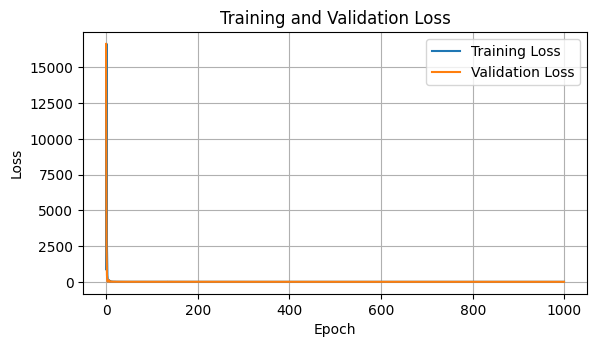

In [17]:
plot_train_val_loss(train_loss, test_loss)

# Final model performance 

This is simply to load the best model during training and to print that loss  
Has no other purpose 

Test loss: 0.7574


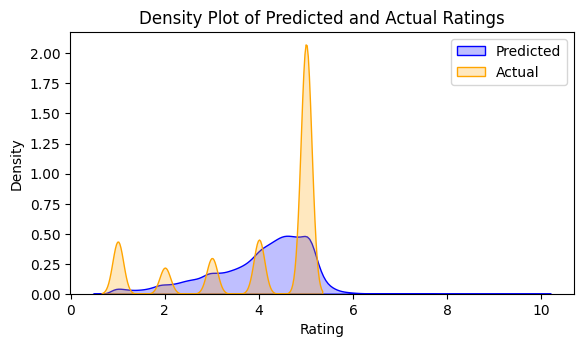

In [18]:
model.load_state_dict(best_model)
final_evaluation(model, test_edge_index, test_edge_weights, user_nodes, product_nodes, device, True)

# Metrics 

We have two kinds
1. Recall at 10
2. NDCG at 10

Recall is slow, 5 min  
NDCG is a work in progress so TBC

In [19]:
product_idx_tensor = torch.tensor(list(prod_id_to_idx.values()), dtype=torch.long, device = device)
test_edges_grp = test_user_edges.groupby("user_idx").prod_idx.apply(list).reset_index()
test_edges_users = test_edges_grp.user_idx.to_list()

In [20]:
# predictions = get_top_k_preds(model, test_edges_users, 10, 32, user_nodes, product_nodes, product_idx_tensor, device) # about 5 min to run
# test_edges_grp["prediction"] = list(torch.vstack(predictions).cpu().numpy())
# test_edges_grp["match_count"] = test_edges_grp.apply(lambda x: len(set(x.prod_idx).intersection(set(x.prediction))), axis = 1)

In [21]:
# # Overall recall
# (test_edges_grp["match_count"] / test_edges_grp.prod_idx.apply(len)).mean()

In [22]:
# # Only those with prior history 
# existing_test_edges_grp = test_edges_grp[test_edges_grp.user_idx.isin(train_user_df.user_id.apply(lambda x: user_id_to_idx[x]))]
# (existing_test_edges_grp["match_count"] / existing_test_edges_grp.prod_idx.apply(len)).mean()

# Show recomendations 

This is just to sample and see what kind of results we get   
I am going to do three kinds of sampling
1. Pure random of the test set 
2. Select test set that have some existance in the training set 
3. Take the test set that dont have existance in the training set but use their user node information 


But first we need to create a reverse mapping that does the offset 
Also need to load up a df to map ids to titles

In [23]:
title_mapping = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = ["parent_asin", "title"])
prod_idx_to_id = {idx - offset: asin for asin, idx in prod_id_to_idx.items()}

In [24]:
# The pure random 
user_id = test_user_df.user_id.sample(1).item()
recommended_products, predictions = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")

Product 1: 10PC Plastic Acrylic Nail Art Soak Off Cap Clip UV Gel Polish Remover Wrap Tool Rose Red by AHAOMG
Product 2: Posh Kick Pro LTE L520 NEW Cell Phone Case with Wrist Strap to help stay organized
Product 3: A pair metal Practice Training Trainer Butterfly Balisong Style Knife Comb Cool Sport
Product 4: Wee Ones Little Girls' Print Bow on a WeeStay No Slip Clip, Whale, King
Product 5: WAWO 50 Pcs Natural Fan-shaped False Nail Art Tips Sticks Polish Gel Salon Display Chart Practice Tool
Product 6: Pet Heroic Knitted Dog Cat Leg Warmer with Rubber Reinforcement, Knitted Dog Leg Hock Protector&Cat Leg Hock Protector, Suitable for Small&Medium Dogs Cats
Product 7: Original Sprout Miracle Detangler 4oz, Model:
Product 8: Heatoe 200 Pcs 2.36 Inch U Shaped Hair Pins Kit with Pink Metal Storage Box, Black Bobby Pins for Women Girls Hair Decoration
Product 9: SODIAL(R) 2 Pcs Flexible Metal Sponge Hair Styling Curler Bun Maker Tool for Women
Product 10: My Sky 500 Pcs Nail Art Guide Form 

In [25]:
# The user with some data 
existing_test_users = test_user_df[test_user_df.user_id.isin(train_user_df.user_id)].copy()[["user_id"]]

In [26]:
user_id = existing_test_users.user_id.sample(1).item()
recommended_products, predictions = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")

Product 1: Posh Kick Pro LTE L520 NEW Cell Phone Case with Wrist Strap to help stay organized
Product 2: 10PC Plastic Acrylic Nail Art Soak Off Cap Clip UV Gel Polish Remover Wrap Tool Rose Red by AHAOMG
Product 3: A pair metal Practice Training Trainer Butterfly Balisong Style Knife Comb Cool Sport
Product 4: Wee Ones Little Girls' Print Bow on a WeeStay No Slip Clip, Whale, King
Product 5: 500pcs Coffin Ballerina Nail Tips Fashion Long False Nails Tips Half Cover DIY Acrylic Fake Nails 10 Sizes (BEIGE)
Product 6: Heatoe 200 Pcs 2.36 Inch U Shaped Hair Pins Kit with Pink Metal Storage Box, Black Bobby Pins for Women Girls Hair Decoration
Product 7: Pet Heroic Knitted Dog Cat Leg Warmer with Rubber Reinforcement, Knitted Dog Leg Hock Protector&Cat Leg Hock Protector, Suitable for Small&Medium Dogs Cats
Product 8: Original Sprout Miracle Detangler 4oz, Model:
Product 9: WAWO 50 Pcs Natural Fan-shaped False Nail Art Tips Sticks Polish Gel Salon Display Chart Practice Tool
Product 10: Mak

In [27]:
# The boosted way
# This is just to see if existing data (a bit of data leak) can help improve performance 
boosted_additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()
boosted_user_df = pd.concat([train_user_df, boosted_additional_test_users])
boosted_user_embed = torch.tensor(np.vstack(boosted_user_df["embedding"].values))
boosted_user_info = torch.tensor(boosted_user_df.drop(["user_id", "embedding"], axis = 1).to_numpy())
boosted_user_nodes = torch.cat([boosted_user_embed, boosted_user_info], dim = 1)

In [ ]:
user_id = boosted_user_df.user_id.sample(1).item()
recommended_products, predictions = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")

Product 1: Posh Kick Pro LTE L520 NEW Cell Phone Case with Wrist Strap to help stay organized
Product 2: 10PC Plastic Acrylic Nail Art Soak Off Cap Clip UV Gel Polish Remover Wrap Tool Rose Red by AHAOMG
Product 3: 500pcs Coffin Ballerina Nail Tips Fashion Long False Nails Tips Half Cover DIY Acrylic Fake Nails 10 Sizes (BEIGE)
Product 4: Wee Ones Little Girls' Print Bow on a WeeStay No Slip Clip, Whale, King
Product 5: A pair metal Practice Training Trainer Butterfly Balisong Style Knife Comb Cool Sport
Product 6: Heatoe 200 Pcs 2.36 Inch U Shaped Hair Pins Kit with Pink Metal Storage Box, Black Bobby Pins for Women Girls Hair Decoration
Product 7: Makartt Paraffin Wax Liners, Larger and Thicker Plastic Hand and Foot Bags, Plastic Paraffin Bath Mitt Glove and Sock Liners for Therabath, Wax Treatment and Paraffin Wax Machine 50Count E-03
Product 8: Pet Heroic Knitted Dog Cat Leg Warmer with Rubber Reinforcement, Knitted Dog Leg Hock Protector&Cat Leg Hock Protector, Suitable for Small&

: 